Shape: (32648, 6)
                              bike_name   price       city  kms_driven  \
0    TVS Star City Plus Dual Tone 110cc   35000  Ahmedabad       17654   
1           Royal Enfield Classic 350cc  119900      Delhi       11000   
2                  Triumph Daytona 675R  600000      Delhi         110   
3                  TVS Apache RTR 180cc   65000  Bangalore       16329   
4  Yamaha FZ S V 2.0 150cc-Ltd. Edition   80000  Bangalore       10000   

         owner  age  
0  First Owner    3  
1  First Owner    4  
2  First Owner    8  
3  First Owner    4  
4  First Owner    3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32648 entries, 0 to 32647
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   bike_name   32648 non-null  object
 1   price       32648 non-null  int64 
 2   city        32648 non-null  object
 3   kms_driven  32648 non-null  int64 
 4   owner       32648 non-null  object
 5   age         

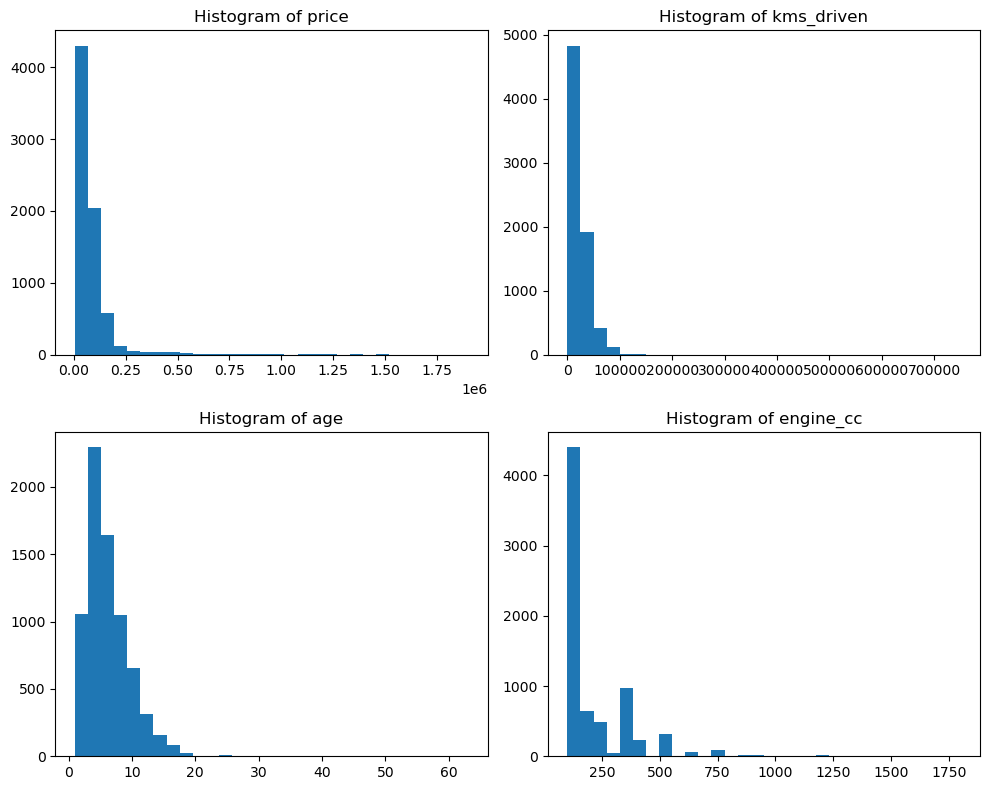

<Figure size 800x400 with 0 Axes>

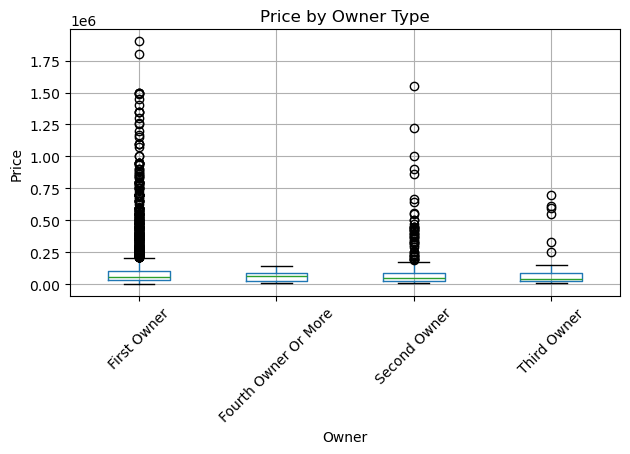

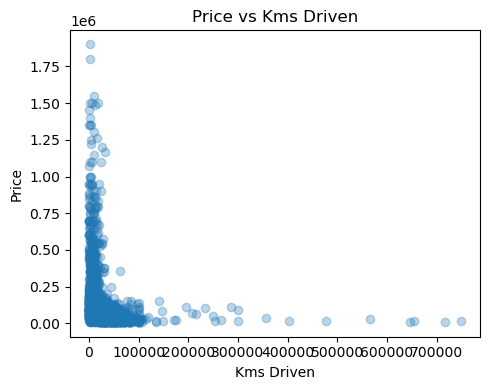

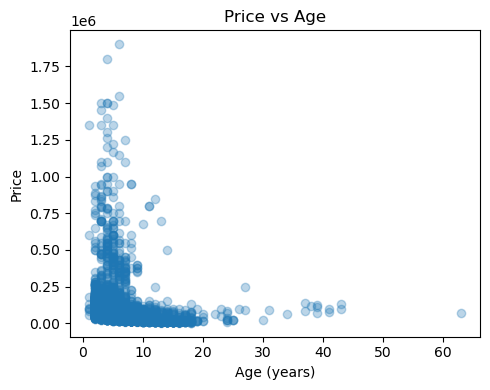

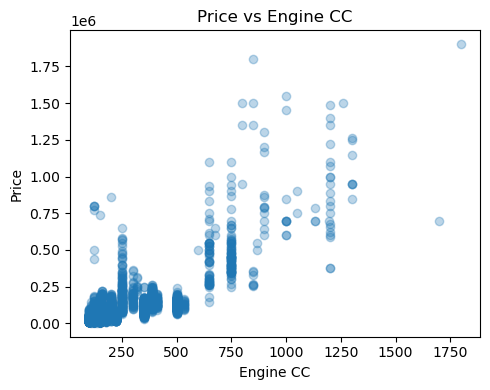

Correlation matrix:
                price  kms_driven       age  engine_cc
price       1.000000   -0.199951 -0.248752   0.760639
kms_driven -0.199951    1.000000  0.367518  -0.147718
age        -0.248752    0.367518  1.000000  -0.134061
engine_cc   0.760639   -0.147718 -0.134061   1.000000


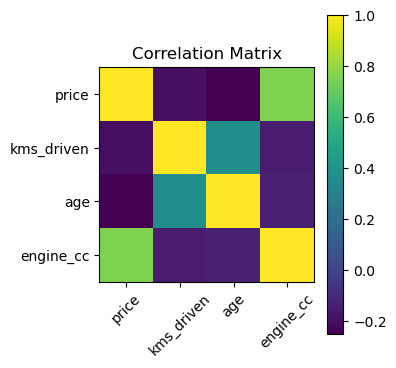

Train shape: (5859, 6)
Test shape: (1465, 6)
=== LinearRegression ===
MAE : 30345.09
MSE : 5088395677.71
RMSE: 71332.99
R2  : 0.7386

=== DecisionTree ===
MAE : 26789.50
MSE : 7386533062.09
RMSE: 85944.94
R2  : 0.6206

=== RandomForest ===
MAE : 21022.72
MSE : 3988669676.08
RMSE: 63155.92
R2  : 0.7951

=== GradientBoosting ===
MAE : 22339.75
MSE : 4181250013.54
RMSE: 64662.59
R2  : 0.7852

=== SVR ===
MAE : 57599.49
MSE : 20592384820.13
RMSE: 143500.47
R2  : -0.0577

=== KNN ===
MAE : 22585.18
MSE : 4362849134.88
RMSE: 66051.87
R2  : 0.7759

Model Comparison:
              Model           MAE           MSE           RMSE        R2
2      RandomForest  21022.723366  3.988670e+09   63155.915606  0.795124
3  GradientBoosting  22339.747759  4.181250e+09   64662.585887  0.785232
5               KNN  22585.178020  4.362849e+09   66051.867005  0.775905
0  LinearRegression  30345.086947  5.088396e+09   71332.991510  0.738637
1      DecisionTree  26789.501251  7.386533e+09   85944.942039  0.620

In [5]:
# 1. Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Load Data
file_path = "C:\\Users\\aprec\\Downloads\\data1_Bikes_data (1).csv"  # change if needed
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print(df.head())
print(df.info())

# 3. Basic Cleaning & Feature Engineering
# (a) Remove duplicates if any
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

# (b) Check for missing values
print("Missing values before engineering:\n", df.isna().sum())

# (c) Optional: derive bike_brand from bike_name
def extract_brand(name):
    if isinstance(name, str):
        return name.split()[0]
    return "Unknown"

df["bike_brand"] = df["bike_name"].apply(extract_brand)

# (d) Derive engine_cc from bike_name, if present (e.g. '150cc', '350cc')
def extract_engine_cc(name):
    if isinstance(name, str):
        match = re.search(r"(\d{2,4})cc", name.lower())
        if match:
            return int(match.group(1))
    return np.nan

df["engine_cc"] = df["bike_name"].apply(extract_engine_cc)

# Check how many missing in engine_cc
print("Missing engine_cc:", df["engine_cc"].isna().sum())

# Impute missing engine_cc with median by brand (if available) else global median
brand_cc_median = df.groupby("bike_brand")["engine_cc"].transform("median")
df["engine_cc"] = df["engine_cc"].fillna(brand_cc_median)

global_cc_median = df["engine_cc"].median()
df["engine_cc"] = df["engine_cc"].fillna(global_cc_median)

# Verify no missing in important numeric variables
print(df[["price", "kms_driven", "age", "engine_cc"]].isna().sum())

# (e) Treat any obvious impossible values if needed
# Example: remove rows with price <= 0 or kms_driven < 0 or age < 0
df = df[(df["price"] > 0) & (df["kms_driven"] >= 0) & (df["age"] >= 0)]
print("Shape after basic logical filtering:", df.shape)

# 4. Exploratory Data Analysis (EDA)

# (a) Summary statistics
print(df[["price", "kms_driven", "age", "engine_cc"]].describe())

# (b) Histograms
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

numeric_cols = ["price", "kms_driven", "age", "engine_cc"]
for ax, col in zip(axes, numeric_cols):
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

# (c) Boxplot of price by owner
plt.figure(figsize=(8, 4))
df.boxplot(column="price", by="owner", rot=45)
plt.title("Price by Owner Type")
plt.suptitle("")
plt.xlabel("Owner")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# (d) Scatter plots
plt.figure(figsize=(5, 4))
plt.scatter(df["kms_driven"], df["price"], alpha=0.3)
plt.xlabel("Kms Driven")
plt.ylabel("Price")
plt.title("Price vs Kms Driven")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(df["age"], df["price"], alpha=0.3)
plt.xlabel("Age (years)")
plt.ylabel("Price")
plt.title("Price vs Age")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(df["engine_cc"], df["price"], alpha=0.3)
plt.xlabel("Engine CC")
plt.ylabel("Price")
plt.title("Price vs Engine CC")
plt.tight_layout()
plt.show()

# (e) Correlation matrix for numeric variables
numeric_for_corr = df[["price", "kms_driven", "age", "engine_cc"]]
corr = numeric_for_corr.corr()
print("Correlation matrix:\n", corr)

plt.figure(figsize=(4, 4))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


# 5. Train-Test Split

target = "price"
features = ["kms_driven", "age", "engine_cc", "city", "owner", "bike_brand"]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 6. Preprocessing Pipelines


numeric_features = ["kms_driven", "age", "engine_cc"]
categorical_features = ["city", "owner", "bike_brand"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 7. Define Models

models = {
    # Baseline linear regression (no assumptions checked)
    "LinearRegression": LinearRegression(),

    # 5 ML models
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
}

# 8. Train and Evaluate Models

results = []

for name, model in models.items():
    # Create a pipeline: preprocessing + model
    clf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    # Fit the model
    clf.fit(X_train, y_train)

    # Predictions on test set
    y_pred = clf.predict(X_test)

    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
    })

    print(f"=== {name} ===")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2  : {r2:.4f}")
    print()

# 9. Compare Models
results_df = pd.DataFrame(results)
# Sort by RMSE ascending (best = lowest RMSE)
results_df = results_df.sort_values(by="RMSE", ascending=True)

print("Model Comparison:")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
print("\nBest model based on RMSE:", best_model_name)


In [7]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# ============================================
# 2. LOAD DATA
# ============================================
file_path = r"C:\Users\aprec\Downloads\data2_Crop_data.csv"   # your path
df = pd.read_csv(file_path)

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head())
print(df.info())

# ============================================
# 3. BASIC CLEANING & MISSING VALUES
# ============================================

print("Missing values:\n", df.isna().sum())

numeric_cols = [
    "N_SOIL", "P_SOIL", "K_SOIL",
    "TEMPERATURE", "HUMIDITY", "ph",
    "RAINFALL", "CROP_PRICE"
]

for col in numeric_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# ============================================
# 4. TARGET ENCODING (CROP)
# ============================================

target_col = "CROP"

label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col])

print("\nUnique crops (encoded) BEFORE filtering:")
print(dict(zip(label_encoder.classes_,
               label_encoder.transform(label_encoder.classes_))))

# ============================================
# 5. REMOVE RARE CLASSES (COUNT < 2)
# ============================================

class_counts = df[target_col].value_counts()
print("\nClass counts before filtering:\n", class_counts)

valid_classes = class_counts[class_counts >= 2].index
df = df[df[target_col].isin(valid_classes)].copy()

print("\nShape after removing rare classes:", df.shape)
print("Class counts after filtering:\n", df[target_col].value_counts())

# 👉 Recompute list of PRESENT classes and their names
present_classes = np.sort(df[target_col].unique())
present_class_names = label_encoder.inverse_transform(present_classes)

print("\nNumber of classes after filtering:", len(present_classes))

# ============================================
# 6. FEATURE SELECTION
# ============================================

X = df[numeric_cols]
y = df[target_col]

# ============================================
# 7. TRAIN-TEST SPLIT (stratified)
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# ============================================
# 8. FEATURE SCALING
# ============================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 9. DEFINE MODELS
# ============================================

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "ANN": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        max_iter=500,
        random_state=42
    )
}

# ============================================
# 10. TRAIN & EVALUATE EACH MODEL
# ============================================

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=present_classes)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_score": f1
    })

    print(f"\n========== {name} ==========")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix (subset classes):\n", cm)

    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        zero_division=0,
        labels=present_classes,          # only present labels
        target_names=present_class_names # matching names
    ))

# ============================================
# 11. MODEL COMPARISON TABLE
# ============================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print("\n=== Model Comparison (Sorted by Accuracy) ===")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
print("\nBest model based on Accuracy:", best_model_name)


Columns: ['STATE', 'SOIL_TYPE', 'N_SOIL', 'P_SOIL', 'K_SOIL', 'TEMPERATURE', 'HUMIDITY', 'ph', 'RAINFALL', 'CROP_PRICE', 'CROP']
Shape: (2200, 11)
                 STATE   SOIL_TYPE  N_SOIL  P_SOIL  K_SOIL  TEMPERATURE  \
0  Andaman and Nicobar  Sandy soil      90      42      43    20.879744   
1  Andaman and Nicobar  Sandy soil      85      58      41    21.770462   
2  Andaman and Nicobar  Sandy soil      60      55      44    23.004459   
3  Andaman and Nicobar  Sandy soil      74      35      40    26.491096   
4  Andaman and Nicobar  Sandy soil      78      42      42    20.130175   

    HUMIDITY        ph    RAINFALL  CROP_PRICE           CROP  
0  82.002744  6.502985  202.935536        7000     Amaranthus  
1  80.319644  7.038096  226.655537        5000   Green Banana  
2  82.320763  7.840207  263.964248        7000  Ladies Finger  
3  80.158363  6.980401  242.864034        7000   Bitter Gourd  
4  81.604873  7.628473  262.717340      120000   Black pepper  
<class 'pandas.cor

C:\Users\aprec\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Initial data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2018-07-31 to 2025-07-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes
None
            Revenue
Date               
2018-07-31     7.64
2018-10-31     7.45
2019-01-31     7.52
2019-04-30     7.95
2019-07-31     7.71

Time series after setting freq & interpolation:
Length: 84 | Non-missing: 0
Date
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
2018-12-01   NaN
Freq: MS, Name: Revenue, dtype: float64


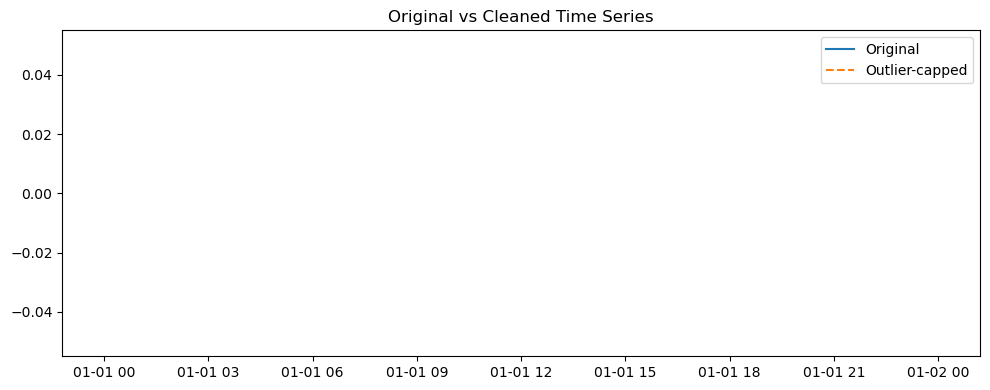

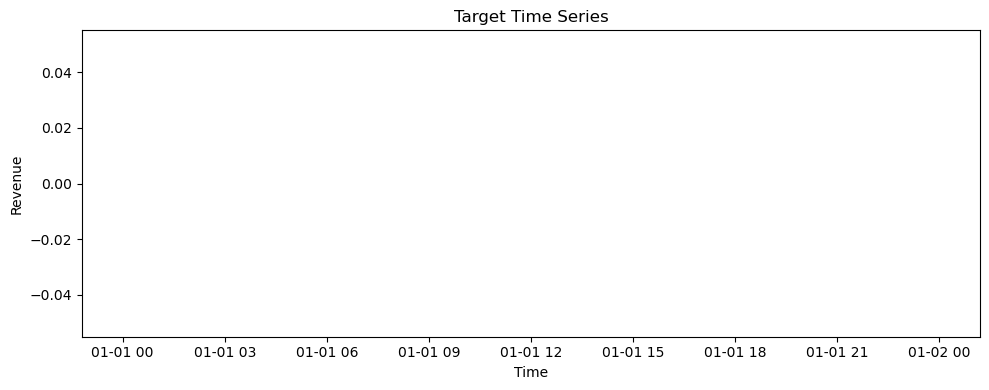


Augmented Dickey-Fuller Test: Original Series
Length after dropna: 0
❗ Not enough data points for ADF test (need at least ~10). Skipping.
❗ Not enough data for ACF/PACF of original series.

Augmented Dickey-Fuller Test: 1st Difference
Length after dropna: 0
❗ Not enough data points for ADF test (need at least ~10). Skipping.
❗ Not enough data for ACF/PACF of differenced series.

Train size: 72
Test size : 12

==== ARIMA ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


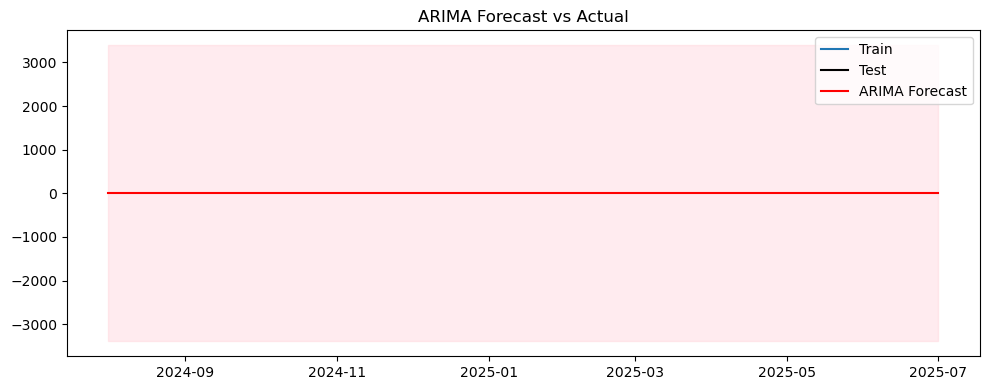


==== SARIMA ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


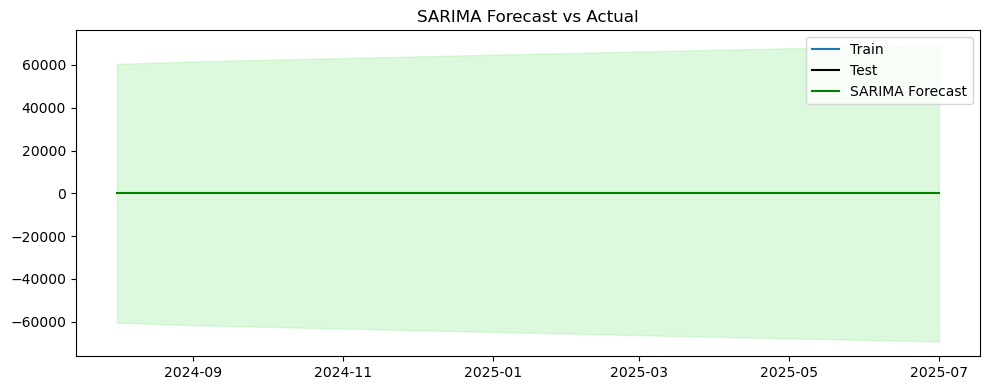


Exogenous variable (growth_rate) head:
            growth_rate
Date                   
2018-08-01          0.0
2018-09-01          0.0
2018-10-01          0.0
2018-11-01          0.0
2018-12-01          0.0

==== ARIMAX ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


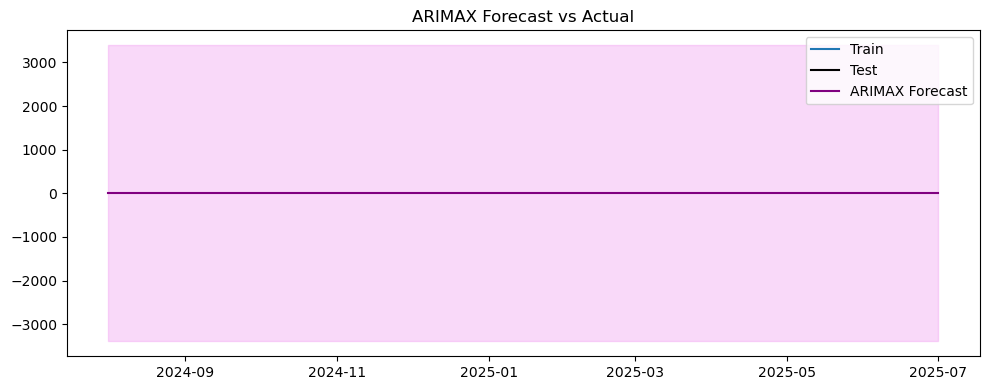


==== SARIMAX ====
❗ No valid (non-NaN) true-pred pairs to evaluate.


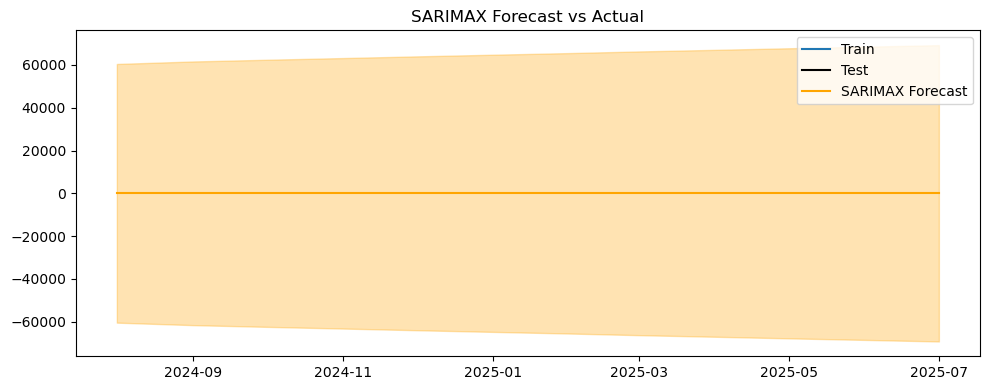


=== Model Comparison ===
     Model   AIC        BIC  RMSE  MAPE
0    ARIMA   6.0  12.702320   NaN   NaN
1   SARIMA  10.0  19.033312   NaN   NaN
2   ARIMAX   8.0  16.936426   NaN   NaN
3  SARIMAX  12.0  22.839975   NaN   NaN


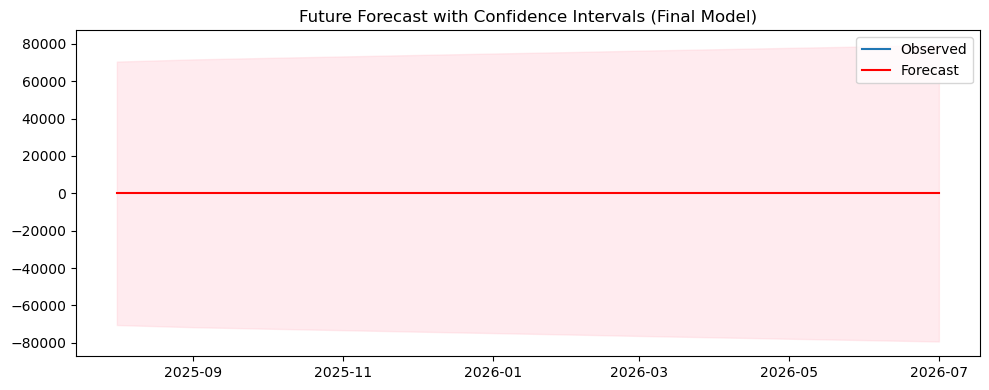


Future forecast values:
2025-08-01    0.0
2025-09-01    0.0
2025-10-01    0.0
2025-11-01    0.0
2025-12-01    0.0
2026-01-01    0.0
2026-02-01    0.0
2026-03-01    0.0
2026-04-01    0.0
2026-05-01    0.0
2026-06-01    0.0
2026-07-01    0.0
Freq: MS, Name: predicted_mean, dtype: float64


In [17]:
# ============================================================
# TIME-SERIES FORECASTING: ARIMA / SARIMA / ARIMAX / SARIMAX
# ============================================================

# 0. IMPORT LIBRARIES
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# 1. LOAD & PREPROCESS DATA
# ------------------------------------------------------------
file_path = r"C:\Users\aprec\Downloads\data3_Cardiofocus_revenue.csv"
date_col   = "Date"       # column with dates
target_col = "Revenue"    # column with revenue/sales/target series

df = pd.read_csv(file_path)

# Convert date column to datetime and set as index
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col).set_index(date_col)

print("Initial data info:")
print(df.info())
print(df.head())

# Use only the target for time-series
ts = df[target_col].astype(float)

# Set frequency (assuming monthly; change 'MS' if needed)
ts = ts.asfreq('MS')

# Handle missing values
ts = ts.interpolate(method='linear')

print("\nTime series after setting freq & interpolation:")
print("Length:", len(ts), "| Non-missing:", ts.notna().sum())
print(ts.head())

# 2. OUTLIER DETECTION (simple IQR-based capping)
# ------------------------------------------------------------
def cap_outliers(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

ts_clean = cap_outliers(ts)

# Plot original vs cleaned
plt.figure(figsize=(10, 4))
plt.plot(ts, label="Original")
plt.plot(ts_clean, label="Outlier-capped", linestyle="--")
plt.title("Original vs Cleaned Time Series")
plt.legend()
plt.tight_layout()
plt.show()

# Use cleaned series as final series
ts = ts_clean.copy()

# 3. STATIONARITY CHECK (SAFE ADF TEST) & TSA PLOTS
# ------------------------------------------------------------
def adf_test(series, title=""):
    s = series.dropna()
    print(f"\nAugmented Dickey-Fuller Test: {title}")
    print("Length after dropna:", len(s))

    # If too few points, skip ADF
    if len(s) < 10:
        print("❗ Not enough data points for ADF test (need at least ~10). Skipping.")
        return

    try:
        result = adfuller(s, autolag="AIC")
    except ValueError as e:
        print("❗ ADF test error:", e)
        print("   (Series may be constant or invalid.)")
        return

    labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations"]
    for val, label in zip(result[:4], labels):
        print(f"{label}: {val}")
    for key, val in result[4].items():
        print(f"Critical Value ({key}): {val}")
    if result[1] <= 0.05:
        print("=> Series is likely STATIONARY (reject H0).")
    else:
        print("=> Series is likely NON-STATIONARY (fail to reject H0).")

# Plot series
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title("Target Time Series")
plt.xlabel("Time")
plt.ylabel(target_col)
plt.tight_layout()
plt.show()

# ADF test on original
adf_test(ts, title="Original Series")

# ACF & PACF for original (if enough points)
if ts.dropna().shape[0] > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts.dropna(), ax=axes[0], lags=24)
    axes[0].set_title("ACF - Original Series")
    plot_pacf(ts.dropna(), ax=axes[1], lags=24, method="ywm")
    axes[1].set_title("PACF - Original Series")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data for ACF/PACF of original series.")

# 4. DIFFERENCING TO ACHIEVE STATIONARITY (if needed)
# ------------------------------------------------------------
ts_diff = ts.diff().dropna()

adf_test(ts_diff, title="1st Difference")

if ts_diff.shape[0] > 10:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(ts_diff, ax=axes[0], lags=24)
    axes[0].set_title("ACF - 1st Difference")
    plot_pacf(ts_diff, ax=axes[1], lags=24, method="ywm")
    axes[1].set_title("PACF - 1st Difference")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data for ACF/PACF of differenced series.")

# Differencing order (set based on tests/plots)
d = 1

# 5. TRAIN-TEST SPLIT
# ------------------------------------------------------------
test_size = 12  # last 12 periods as test

if len(ts) <= test_size:
    raise ValueError("Series too short for test_size=12. Reduce test_size or use more data.")

train_ts = ts.iloc[:-test_size]
test_ts  = ts.iloc[-test_size:]

print("\nTrain size:", train_ts.shape[0])
print("Test size :", test_ts.shape[0])

# 6. HELPER FUNCTIONS: METRICS & RESIDUAL DIAGNOSTICS
# ------------------------------------------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(true, pred, model_result, model_name="Model"):
    # Combine true and predicted values into one DataFrame
    df_eval = pd.concat([true, pred], axis=1)
    df_eval.columns = ["y_true", "y_pred"]

    before_len = len(df_eval)
    df_eval = df_eval.dropna()
    after_len = len(df_eval)

    # If all values are NaN, skip evaluation
    if after_len == 0:
        print(f"\n==== {model_name} ====")
        print("❗ No valid (non-NaN) true-pred pairs to evaluate.")
        return {
            "Model": model_name,
            "AIC": model_result.aic,
            "BIC": model_result.bic,
            "RMSE": np.nan,
            "MAPE": np.nan
        }

    print(f"\n[{model_name}] Using {after_len} valid points (dropped {before_len - after_len} NaNs).")

    y_true = df_eval["y_true"].values
    y_pred = df_eval["y_pred"].values

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)

    print(f"\n==== {model_name} ====")
    print(f"AIC  : {model_result.aic:.2f}")
    print(f"BIC  : {model_result.bic:.2f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape_val:.3f}%")

    # Residual diagnostics
    residuals = model_result.resid
    print("\nResidual summary:")
    print(residuals.describe())

    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
    print("\nLjung-Box test (lag 10):")
    print(lb_test)

    # Residual plot
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f"Residuals - {model_name}")
    plt.tight_layout()
    plt.show()

    return {
        "Model": model_name,
        "AIC": model_result.aic,
        "BIC": model_result.bic,
        "RMSE": rmse,
        "MAPE": mape_val
    }

# 7. BASE MODELS: ARIMA & SARIMA
# ------------------------------------------------------------
p, q = 1, 1        # example; tune using ACF/PACF
P, D, Q, m = 1, 1, 1, 12   # seasonal pattern (monthly, yearly seasonality)

metrics_list = []

# 7.1 ARIMA (no seasonality, no exogenous)
arima_model = SARIMAX(train_ts,
                      order=(p, d, q),
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
arima_result = arima_model.fit(disp=False)

arima_forecast = arima_result.get_forecast(steps=test_size)
arima_pred_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, arima_pred_mean, arima_result, "ARIMA")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, arima_pred_mean, label="ARIMA Forecast", color="red")
plt.fill_between(test_ts.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# 7.2 SARIMA (seasonality, no exogenous)
sarima_model = SARIMAX(train_ts,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

sarima_forecast = sarima_result.get_forecast(steps=test_size)
sarima_pred_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, sarima_pred_mean, sarima_result, "SARIMA")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, sarima_pred_mean, label="SARIMA Forecast", color="green")
plt.fill_between(test_ts.index,
                 sarima_ci.iloc[:, 0],
                 sarima_ci.iloc[:, 1],
                 color="lightgreen", alpha=0.3)
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# 8. CREATE GROWTH RATE (EXOGENOUS VARIABLE)
# ------------------------------------------------------------
growth = ts.pct_change() * 100
growth = growth.replace([np.inf, -np.inf], np.nan).fillna(0)

exog = growth.to_frame(name="growth_rate")
exog_train = exog.iloc[:-test_size]
exog_test  = exog.iloc[-test_size:]

print("\nExogenous variable (growth_rate) head:")
print(exog.head())

# 9. ARIMAX & SARIMAX (WITH EXOGENOUS VARIABLES)
# ------------------------------------------------------------
# 9.1 ARIMAX (no seasonality, with exog)
arimax_model = SARIMAX(train_ts,
                       exog=exog_train,
                       order=(p, d, q),
                       seasonal_order=(0, 0, 0, 0),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

arimax_forecast = arimax_result.get_forecast(steps=test_size, exog=exog_test)
arimax_pred_mean = arimax_forecast.predicted_mean
arimax_ci = arimax_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, arimax_pred_mean, arimax_result, "ARIMAX")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, arimax_pred_mean, label="ARIMAX Forecast", color="purple")
plt.fill_between(test_ts.index,
                 arimax_ci.iloc[:, 0],
                 arimax_ci.iloc[:, 1],
                 color="violet", alpha=0.3)
plt.title("ARIMAX Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# 9.2 SARIMAX (seasonality + exog)
sarimax_model = SARIMAX(train_ts,
                        exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_result.get_forecast(steps=test_size, exog=exog_test)
sarimax_pred_mean = sarimax_forecast.predicted_mean
sarimax_ci = sarimax_forecast.conf_int()

metrics_list.append(
    evaluate_forecast(test_ts, sarimax_pred_mean, sarimax_result, "SARIMAX")
)

plt.figure(figsize=(10, 4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Test", color="black")
plt.plot(test_ts.index, sarimax_pred_mean, label="SARIMAX Forecast", color="orange")
plt.fill_between(test_ts.index,
                 sarimax_ci.iloc[:, 0],
                 sarimax_ci.iloc[:, 1],
                 color="orange", alpha=0.3)
plt.title("SARIMAX Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# 10. MODEL COMPARISON TABLE
# ------------------------------------------------------------
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values(by="RMSE")
print("\n=== Model Comparison ===")
print(metrics_df)

# 11. FINAL MODEL & FUTURE FORECASTS WITH CONFIDENCE INTERVALS
# ------------------------------------------------------------
final_exog = exog  # full exog for entire series

final_sarimax = SARIMAX(ts,
                        exog=final_exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

n_forecast = 12  # forecast 12 future periods

future_index = pd.date_range(start=ts.index[-1] + ts.index.freq,
                             periods=n_forecast,
                             freq=ts.index.freq)

future_growth = pd.Series(
    exog["growth_rate"].tail(12).mean(),
    index=future_index,
    name="growth_rate"
)
future_exog = future_growth.to_frame()

final_forecast = final_sarimax.get_forecast(steps=n_forecast, exog=future_exog)
final_pred_mean = final_forecast.predicted_mean
final_ci = final_forecast.conf_int()

plt.figure(figsize=(10, 4))
plt.plot(ts.index, ts, label="Observed")
plt.plot(final_pred_mean.index, final_pred_mean, label="Forecast", color="red")
plt.fill_between(final_pred_mean.index,
                 final_ci.iloc[:, 0],
                 final_ci.iloc[:, 1],
                 color="pink", alpha=0.3)
plt.title("Future Forecast with Confidence Intervals (Final Model)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nFuture forecast values:")
print(final_pred_mean)
